In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy.signal import residue, residuez
from scipy.signal import find_peaks
import panel as pn
import panel.widgets as pnw

In [2]:
def get_hist(signal):
    bins = np.logspace(-1, 5, 50)
    vals, bins = np.histogram(signal, bins = bins, density = True)
    bin_middle = (bins[1:] + bins[:-1]) / 2
    return bin_middle, vals

def real_lapl_signal(s,f,t):
    return np.sum(np.exp(-s*t)*f)

def real_lapl_der_signal(s,f,t,n):    
    return np.sum( ((-t)**n )*np.exp(-s*t)*f ) 

def get_poles(f, tt, m, K, p0):
    Lp0K = [real_lapl_der_signal(p0,f,tt,n)/np.math.factorial(n) for n in range(K)][::-1]
    p,q = interpolate.pade(Lp0K[::-1],m,m+1)
    residues = residue(p, q)
    return residues

def sum_exp(tt_, terms = 1):
    residues = residues_term[terms]
    f_res = np.zeros(N)
    for term in np.arange(0, terms):
        f = (residues[0][term] /  (N/(t_end - t_start))) * np.exp((residues[1][term]+p0) * tt_)
        f_res = f_res + f
    return f_res

def splines(x, y, t_start, t_end, N):
    f = interpolate.interp1d(x, y)
    tt = np.linspace(t_start, t_end, N)
    return tt, f(tt)

def factorize_exponentials(dt, pdf, K = 20):
    residues_term = {}
    for term in np.arange(1, 7):
        residues = get_poles(pdf, dt, term, K, p0)
        if (all(res.imag == 0 for res in residues[1]) and all(res < 0 for res in residues[1])):
            residues_term[term] = residues
    return residues_term

def poiss_2scale_prob(scale_long, prob_long, scale_short, signal_length):
    """
    2 scale Poissonian with probability
    """
    bern = np.asarray(np.random.rand(signal_length) < prob_long, dtype=int)
    signal = np.zeros(signal_length)
    for elem in range(signal_length):
        intertime = np.random.exponential(scale = [scale_short, scale_long], size = None) 
        signal[elem] = intertime[bern[elem]]
    return signal


In [3]:
scale_long = 10**3
prob_long = 1/10 #prob. long timescale
scale_short = 10
signal_length = 400000
size_short = 9
size_long = 40000

signal_prob = poiss_2scale_prob(scale_long, prob_long, scale_short, signal_length)

t_start = 10**0
t_end = 10**4
N = 10**4
bin_middle, vals = get_hist(signal_prob)
dt, pdf = splines(bin_middle, vals, t_start, t_end, N)

p0 = 0.0145

K = 20
ss = np.linspace(-0.2,0.2,1000)

In [4]:
def plot_laplace(p0, term):
    fig, ax = plt.subplots(figsize=(14,5))
    ax.plot(ss,[real_lapl_signal(s,pdf,dt) for s in ss],label="Laplace", zorder = 10)
    Lp0K = [real_lapl_der_signal(p0,pdf,dt,n)/np.math.factorial(n) for n in range(K)][::-1]
    ax.plot(ss,[np.poly1d(Lp0K)(s-p0) for s in ss],label="Taylor(Laplace)")
    p,q = interpolate.pade(Lp0K[::-1],term,term+1)
    residues = residue(p,q)
    ax.plot(ss,[np.poly1d(p)(s-p0) / np.poly1d(q)(s-p0) for s in ss],label="Pade(Laplace)")

    x = [np.poly1d(p)(s-p0) /np.poly1d(q)(s-p0) for s in ss]
    peaks, _ = find_peaks(x, height=0)

    ax.plot([p0,p0],[1e-5,1e5],label="p0", linestyle = 'dashed')
    ax.vlines(residue(p,q)[1]+p0, ymin = 0, ymax = 0.2, linestyles = 'dashed', 
               linewidths = 4, color = 'black', label = 'poles', zorder = 20)

    ax.set_yscale('log')
    ax.set_ylim([0.1,10000])
    ax.set_xlim(-0.15, 0.1)
    ax.legend()
    ax.grid()
    plt.tight_layout()
    return fig

def plot_pdf(term, figsize = 5):
    fig, ax = plt.subplots(figsize = (figsize, figsize))
    _ = ax.plot(bin_middle, vals, 'o', c = 'lightblue', label = 'Real data');
    _ = ax.plot(dt, pdf, 'o', label = 'Linear spline');
    f_res = sum_exp(dt, term)
    _ = ax.plot(dt, f_res, '.', c = 'r', ms = 5, 
             label = f'Approx with {term}-terms');
    ax.legend()
    ax.grid()
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlim(10**-2, 10**6)
    ax.set_ylim(10**-10, 10**1)
    ax.set_ylabel('PDF')
    ax.set_xlabel('$\Delta T$')
    plt.tight_layout()
    return fig

/home/pouw/anaconda3/envs/CF37/lib/python3.7/site-packages/scipy/interpolate/_pade.py:62: LinAlgWarning: Ill-conditioned matrix (rcond=8.18366e-18): result may not be accurate.
  pq = linalg.solve(C, an)
/home/pouw/anaconda3/envs/CF37/lib/python3.7/site-packages/scipy/interpolate/_pade.py:62: LinAlgWarning: Ill-conditioned matrix (rcond=2.07636e-21): result may not be accurate.
  pq = linalg.solve(C, an)
/home/pouw/anaconda3/envs/CF37/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in exp
  
/home/pouw/anaconda3/envs/CF37/lib/python3.7/site-packages/numpy/ma/core.py:6846: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)


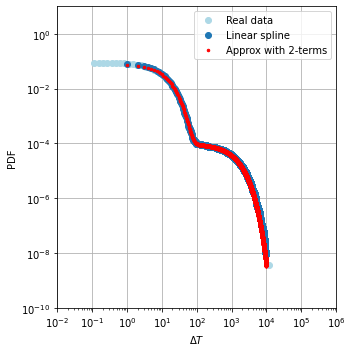

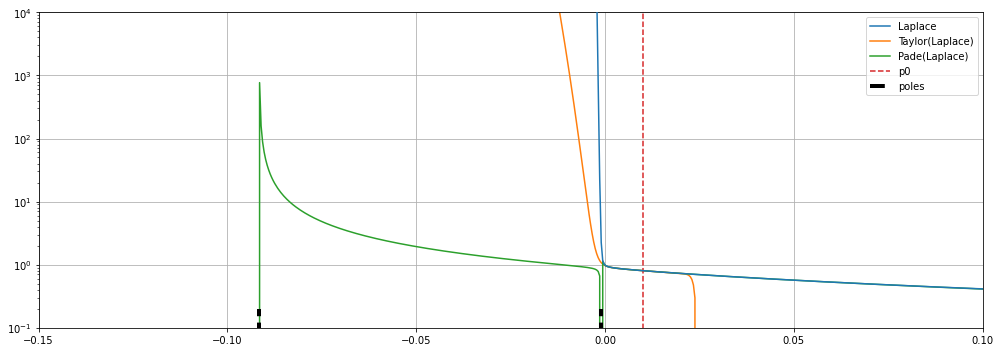

In [5]:
residues_term = factorize_exponentials(dt, pdf)        

term_no = pn.widgets.RadioButtonGroup(name='term', value=2, options=list(residues_term.keys()))
p0_value  = pn.widgets.FloatSlider(name='p0', value=0.01, start=0.005, end=0.02, step=0.005)

pade_plot = pn.bind(plot_laplace, p0_value, term_no);
pdf_plot_frame = pn.bind(plot_pdf, term_no)

widgets   = pn.Column("<br>\n# Pade approximation", p0_value, "Select number of terms:", 
                      term_no);
pade_panel = pn.Row(pdf_plot_frame, widgets);
total_panel = pn.Column(pade_panel, pade_plot);

In [6]:
total_panel.show()

Launching server at http://localhost:36405


/home/pouw/anaconda3/envs/CF37/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in exp
  
/home/pouw/anaconda3/envs/CF37/lib/python3.7/site-packages/numpy/ma/core.py:6846: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)
/home/pouw/anaconda3/envs/CF37/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in exp
  
/home/pouw/anaconda3/envs/CF37/lib/python3.7/site-packages/numpy/ma/core.py:6846: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)
/home/pouw/anaconda3/envs/CF37/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in exp
  
/home/pouw/anaconda3/envs/CF37/lib/python3.7/site-packages/scipy/interpolate/_pade.py:62: LinAlgWarning: Ill-conditioned matrix (rcond=1.9152e-18): result may not be accurate.
  pq = linalg.solve(C, an)
/home/pouw/anaconda3/e